# Skills Ladder Group Classification

Skills Ladder is an IT training company based in Gloucestershire, the United Kingdom. This notebook aims to place the firm's IT training clients into groups based on their Excel knowledge. It outlines how scores from questions answered can be organized by difficulty, normalized and multiplied by a weight for better classifications. It also shows how the group size changes when the limits are varied.

## Final score calculation

[1]

$$
Z_{Sn_{𝑖}} = \frac{Sn_{𝑖}-μ_{Sn} }{σ_{Sn} }
$$

[2]

$$
FS_{𝑖} = \frac{ Z_{S1_{𝑖}}W_{1}+...+Z_{Sn_{𝑖}}W_{n} }{n}
$$

Where...

* Z = z-score
* S = score type (incl. total, math, beginner, intermediate, advanced & open question)
* N = number of score types
* μ = mean
* σ = standard deviation
* FS = final score
* Weight





## Read-in data

In [1]:
# imports libraries
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt

# reads-in the processed data
df = pd.read_csv('C:/Users/Jack-/OneDrive/Desktop/Projects/Skills-Ladder-Group-Classification/Responses.csv')

# reduce rows to eliminate uneeded NAs
df = df.iloc[0:52,:]

# view data frame
df.head(6)

,Timestamp,First Name,"Do you have a maths level 2 qualification, which means GCSE maths C (new grade 4) or above, O Level maths or Level 2 Functional Skills?",Opening a spreadsheet or creating a new blank spreadsheet.,"Cell Formatting: How confident are you in formatting cells, including adjusting row and column sizes and applying basic formatting like bold, italics, and underlining?","Basic Functions and Formulas: Rate your ability to use basic functions such as SUM, AVERAGE, and COUNT.",Data Entry and Sorting: Evaluate your proficiency in entering data and using simple sorting techniques in Excel.,Charts and Graphs: Rate your ability to create and modify charts and graphs in Excel.,"Complex Functions (e.g., VLOOKUP, IF): How skilled are you in using more complex functions like VLOOKUP, IF statements, and conditional formatting?",Data Filters and Pivot Tables: How well can you use data filters and create basic pivot tables for data analysis?,"Advanced Data Analysis: Assess your skills in advanced data analysis, including the use of PivotTable features like calculated fields and data groupings.","Macros and VBA: Rate your proficiency in creating and using macros, and if applicable, writing basic VBA (Visual Basic for Applications) scripts.","Problem-Solving and Optimization: How confident are you in using Excel to solve complex problems, optimize processes, and automate repetitive tasks?",What Spreadsheet / Excel skills would you like to improve?,Total Score,Beginner,Intermediate,Advanced
0,12/28/2023 8:31:45,Mark,Yes,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,all,2.0,2.0,0.0,0.0
1,1/3/2024 16:30:11,Michelle,Yes,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Everything i am a beginner at all of it,4.0,4.0,0.0,0.0
2,12/27/2023 9:37:47,Robert,Yes,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Basic to intermediate skills,6.0,6.0,0.0,0.0
3,1/2/2024 14:14:31,Raj,Yes,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Everything,6.0,6.0,0.0,0.0
4,1/3/2024 15:30:44,Annie,Yes,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,My knowledge is very limited,6.0,6.0,0.0,0.0
5,1/4/2024 10:55:56,Sonia,Yes,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"Starting with some basics, nothing too complic...",6.0,6.0,0.0,0.0


## Define score class

In [2]:
# define score class with associated weights
class score_type:
  def __init__(self, name, weight):
    self.name = name
    self.weight = weight

# list names and weights
names = ['Total Score', 'Math Score', 'Beginner', 'Intermediate', 'Advanced', 'Open Question Score']
weights = [1, 1, 1, 4, 8, 8]

# assign classes data
score_types = []
for i in range(len(names)):
    score_types.append( score_type(names[i], weights[i]) )

# print example
print( 'The current weight for ' + score_types[0].name + ' is ' + str(score_types[0].weight) )

The current weight for Total Score is 1


## Other parameters

In [3]:
# words or beginnings of words to search for in the open question to indicate advanced learners
open_question_advanced_words = 'macro|formula|vlookup|advanced|vba|pivot|data|complex'

# the beginner upper limit and advanced lower limit for setting classification boundaries
beginner = -0.85
advanced = 0.85

## Create math score

In [4]:
# creates a math score
math_score = []
for score in df.iloc[:,2]:
    if score=='No':
        math_score.append( 0 )
    else:
        math_score.append( 1 )

df['Math Score'] = math_score

## Create open question score

In [5]:
# creates an open question score based on advanced words
import re

open_question_score = []
for score in df.iloc[:,13]:
    if type(score) != str:
        open_question_score.append( 1 )
    elif re.search(open_question_advanced_words, score.lower()):
        open_question_score.append( 1 )
    else:
        open_question_score.append( 0 )

df['Open Question Score'] = open_question_score

## Convert to z-scores

In [6]:
# returns a normalized z-score for each data point in a range
def z_scores(list):
    mean = np.mean(list)
    sd = np.std(list)
    z_scores = []
    for item in list:
        z_scores.append( (item - mean) / sd )
    return z_scores

for col in score_types:
    df[col.name] = z_scores( df[col.name] )

## Create final score

In [7]:
# works out the final score
def get_final_score(row):
    scores = []
    for score_type in score_types:
        scores.append(df.loc[row,score_type.name] * score_type.weight)
    return sum(scores) / len(scores)

def get_final_scores():
    final_scores = []
    for row in range(len(df)):
        final_scores.append( get_final_score(row) )
    return final_scores

## Classify groups

In [8]:
# classifies groups into one of beginner, intermediate or advanced
def classify(advanced, beginner):
    final_scores = get_final_scores()
    classifications = []
    for i in range(len(final_scores)):
        if final_scores[i] < beginner:
            classifications.append('beginner')
        elif final_scores[i] > advanced:
            classifications.append('advanced')
        else:
            classifications.append('intermediate')
    return classifications

## Original parameters

As we can see from the barplot below, the groups are relatively evenly split. Skills Ladder however want intermediate followed by beginner to be the largest and second largest groups respectively. To alter the relative distribution, we can vary the beginner and advanced limits for classification. 

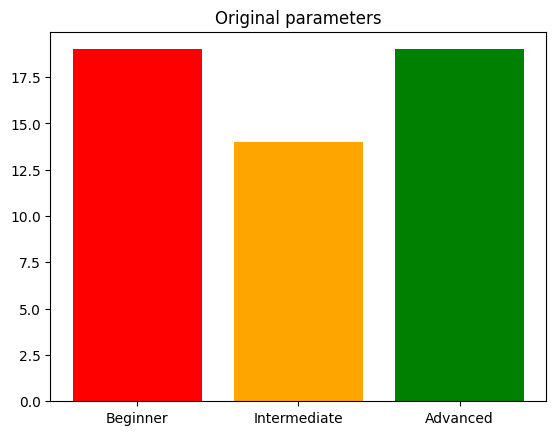

In [9]:
import matplotlib.pyplot

# colors for plotting
colors = ['red', 'orange', 'green']

# classified learners by value count
data = pd.DataFrame({'Level':classify(advanced, beginner)}).value_counts()

# the valued counts data is extracted into a pandas dataframe ordered by level
results_df = pd.DataFrame({'Level': ['Beginner', 'Intermediate', 'Advanced'],
                           'Number': [data['beginner'], data['intermediate'], data['advanced']]})

# plots the distribution
plt.bar(results_df.Level, results_df.Number, color=colors);
plt.title('Original parameters');

## Classification boundaries

The plot below shows that limits of -2 and 2 for beginner and advanced groups respectively would yeild the desired results of larger intermediate groups followed subsequently by beginners and then advanced.

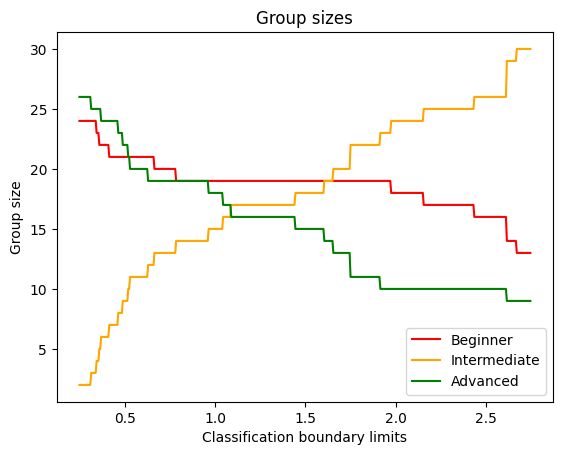

In [15]:
# returns a list of simulated group size results with variable parameters
def vary_limits(start=0.25, increment=0.005, no=500):

    # empty lists
    beginner_group = []
    intermediate_group = []
    advanced_group = []
    index_value = []

    # the staring value for the classification limits
    advanced = start
    beginner = advanced - (advanced*2)

    # iterates through simulations and appends the data to the relevant list
    for i in range(no):
        data = pd.DataFrame({'Level':classify(advanced, beginner)}).value_counts().sort_index()
        beginner_group.append(data['beginner'])
        intermediate_group.append(data['intermediate'])
        advanced_group.append(data['advanced'])
        index_value.append(advanced)

        # increments the limits by the pre-defined increment amount
        advanced = advanced + increment
        beginner = beginner - increment

    # creates a dataframe of the entire results set
    new_data = pd.DataFrame({'beginner':beginner_group,
                             'intermediate':intermediate_group,
                             'advanced':advanced_group})
    new_data.index = index_value
    return new_data

varied_limits_df = vary_limits()

# plots the group size distribution as classification limits change
plt.plot(varied_limits_df.beginner, color='red');
plt.plot(varied_limits_df.intermediate, color='orange');
plt.plot(varied_limits_df.advanced, color='green');
plt.title('Group sizes');
plt.xlabel('Classification boundary limits');
plt.ylabel('Group size');
plt.legend(['Beginner', 'Intermediate', 'Advanced']);